In [9]:
import pymiere

from pymiere import wrappers

# check that a project is opened
project_opened, sequence_active = wrappers.check_active_sequence(crash=False)
if not project_opened:
    raise ValueError("please open a project")

project = pymiere.objects.app.project

# open sequences in UI if none are active
if not sequence_active:
    sequences = wrappers.list_sequences()
    for seq in sequences:
        project.openSequence(sequenceID=seq.sequenceID)
    project.activeSequence = sequences[0]  # set the first sequence in the list as active

# list all videos clip in the active sequence
clips = wrappers.list_video(project.activeSequence)

# get sequence fps (timebase in ticks to be converted to frame per seconds)
fps = 1/(float(project.activeSequence.timebase)/wrappers.TICKS_PER_SECONDS)

print("Sequence as a framerate of {} fps".format(fps))

Track : Vídeo 1
Track : Vídeo 2
Track : Vídeo 3
Sequence as a framerate of 29.982310436842262 fps


In [6]:
import librosa as lb

In [10]:
pathFile = 'C:\\Users\\Carlos\\Twitch\\Laboratorio\\01.Proyecto ACutStic\\input-navidad.mp4'

# Abrimos en el proyecto el archivo de video deseado.
pymiere.objects.app.sourceMonitor.openFilePath(pathFile)

True

In [14]:
from moviepy.video.io.VideoFileClip import VideoFileClip

videoclip = VideoFileClip(pathFile) 
audioclip = videoclip.audio

In [16]:
audioclip.write_audiofile('./output/audiofile.wav')

MoviePy - Writing audio in ./output/audiofile.wav


chunk: 100%|███████████████████████████████████████████████████████████▊| 3184/3197 [00:02<00:00, 724.36it/s, now=None]


MoviePy - Done.


chunk:   1%|▌                                                              | 28/3197 [00:13<25:30,  2.07it/s, now=None]

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [165]:
sy, sr = lb.load(pathFile, sr=None)

In [177]:
sy = lb.amplitude_to_db(sy)

In [270]:
win_s = int(sr / 2)
thres = 60
cdown = 5

cdown_cnt  = cdown
cut_points = np.array([0]) # Añadido inpoint inicial.
is_lower   = False 

for i in np.arange(0, sy.shape[0], win_s):
    
    # Seleccionamos los datos dentro de la ventana.
    sub_y = sy[i:(win_s + i)]
    # Si estamos por debajo del umbral, y veníamos de arriba...
    
    win_est = np.abs(np.mean(sub_y))
        
    if win_est <= thres:
        
        if not is_lower: 
            # Guardamos el sample rate.
            cut_points = np.append(cut_points, i)
            is_lower = True
            cdown_cnt = cdown
            
    elif is_lower and cdown_cnt <= 0:
        is_lower = False
        cut_points = np.append(cut_points, i)
        cdown_cnt = cdown
        
    cdown_cnt -= 1

print(len(cut_points))

39


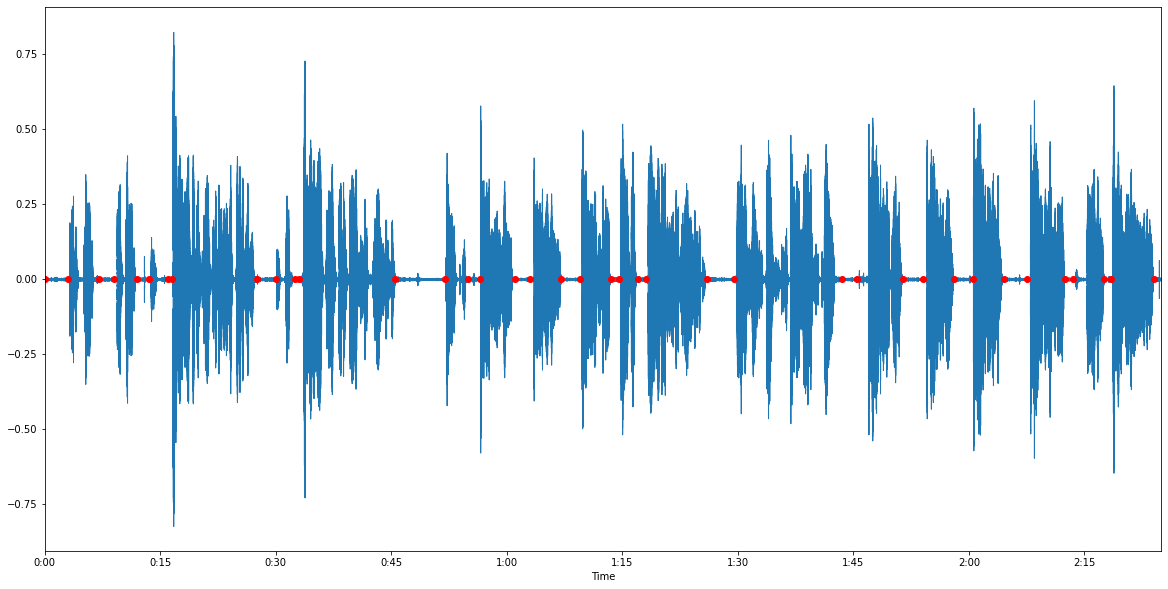

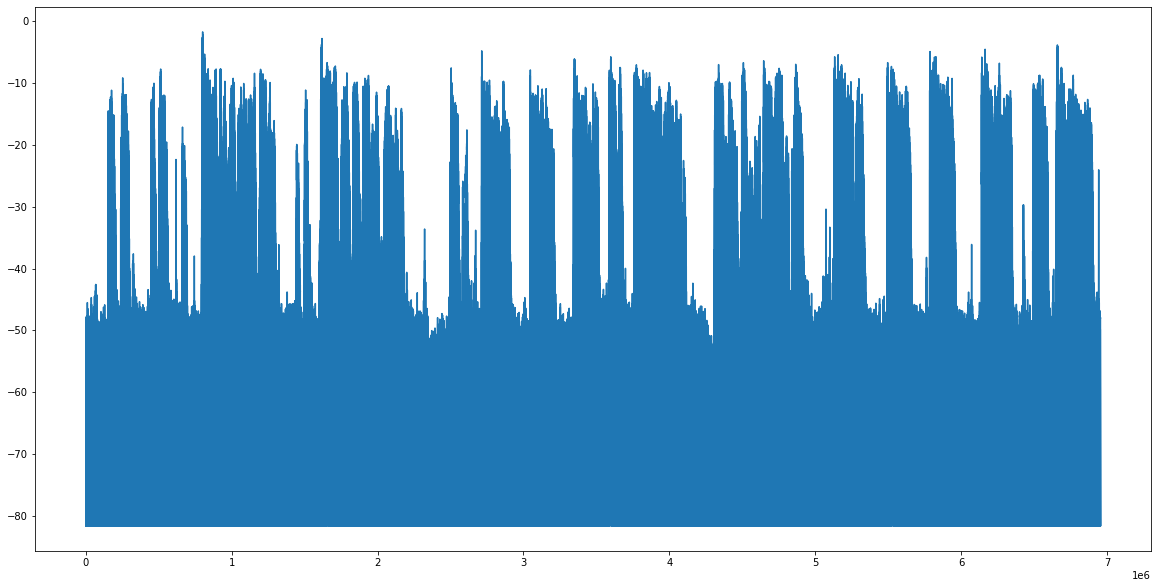

In [281]:
from librosa.display import waveplot

plt.figure(figsize=(20, 10))    
lb.display.waveplot(y, sr)
plt.scatter(cut_points / sr, np.zeros(len(cut_points)), c="red")
plt.show()


plt.figure(figsize=(20, 10))    
# plt.scatter(cut_points, np.zeros(len(cut_points)), c="red")
plt.plot(sy)
plt.show()

In [282]:
from pymiere.core import PymiereBaseObject, PymiereBaseCollection, Array, _format_object_to_py, _format_object_to_es

projectVid = project.rootItem.children[-1]




In [274]:
def setColorLabel(clip, label): 
    clip._eval_on_this_object("setColorLabel({})".format(_format_object_to_es(label)))

In [283]:
ts = 0
clip = project.rootItem.children[-1]

to_remove = True

for i in range(len(cut_points) - 1):
    
        inP = cut_points[i]   / sr
        ouP = cut_points[i+1] / sr

        print(inP, ouP)

        clip.setInPoint(inP,  4)
        clip.setOutPoint(ouP, 4)
        
        setColorLabel(clip, 8 + abs(1 - i % 2)*2)
        project.activeSequence.videoTracks[(i % 2)*2].insertClip(clip, ts)

        ts += (ouP - inP)

0.0 3.0
3.0 7.0
7.0 9.0
9.0 12.0
12.0 13.5
13.5 16.0
16.0 16.5
16.5 27.5
27.5 30.0
30.0 32.5
32.5 33.0
33.0 45.5
45.5 52.0
52.0 55.0
55.0 56.5
56.5 61.0
61.0 63.0
63.0 67.0
67.0 69.5
69.5 73.5
73.5 74.5
74.5 77.0
77.0 78.0
78.0 86.0
86.0 89.5
89.5 103.5
103.5 105.5
105.5 111.5
111.5 114.0
114.0 118.0
118.0 120.5
120.5 124.5
124.5 127.5
127.5 132.5
132.5 133.5
133.5 137.5
137.5 138.5
138.5 144.0
